In [2]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect, text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurment = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#Get the columns for measurement
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Get the columns for station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
session.query(Measurment.date).order_by(Measurment.date).first()

('2010-01-01',)

2016-08-23 00:00:00


c:\Users\logic\anaconda3\envs\dev\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\logic\anaconda3\envs\dev\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


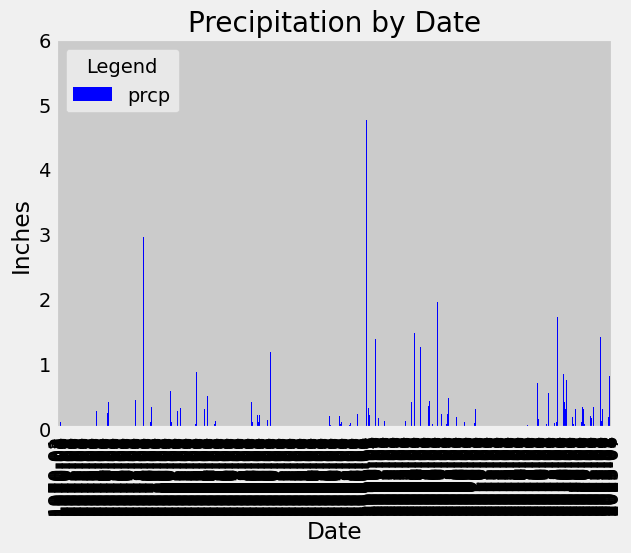

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurment.date).order_by(Measurment.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
first_date = last_date - dt.timedelta(days=365)
print(first_date)

# Perform a query to retrieve the data and precipitation scores
query = """
SELECT *
FROM measurement
"""

# Save the query results as a Pandas DataFrame. Explicitly set the column names
with engine.connect() as connection:
    # Execute the query
    result = connection.execute(text(query))
    
    # Fetch all the data
    data = result.fetchall()
    
    # Define the column names
    columns = ['id', 'station', 'date', 'prcp', 'tobs']
    # Create the Dataframe
    climate_df = pd.DataFrame(data, columns=columns)

# Sort the dataframe by date
climate_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plot = climate_df.plot(kind='bar', x='date',y='prcp', legend=True, color='blue')

# Customize the plot
plot.set_title('Precipitation by Date')
plot.set_ylabel('Inches')
plot.set_ylim(0,6)
plot.set_xlabel('Date')
plot.legend(title='Legend')
#plot.xticks(rotation=45)

# Copilot provided the major_locator function
plot.xaxis.set_major_locator(mdates.MonthLocator())
plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
climate_df['prcp'].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
stations = climate_df['station'].value_counts()

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations.sort_values(ascending=False)

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: count, dtype: int64

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_df = climate_df[climate_df['station']=='USC00519281']
active_df['tobs'].agg(['mean', 'max', 'min'])

mean    71.663781
max     85.000000
min     54.000000
Name: tobs, dtype: float64

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plot.hist(x=active_df['tobs'], color='blue')

(array([ 11.,  26.,  89., 192., 447., 782., 743., 347., 119.,  16.]),
 array([54. , 57.1, 60.2, 63.3, 66.4, 69.5, 72.6, 75.7, 78.8, 81.9, 85. ]),
 <BarContainer object of 10 artists>)

# Close Session

In [16]:
# Close Session
session.close()